In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline


In [2]:
train_set = pd.read_csv('./archive/train.csv')
test_set = pd.read_csv('./archive/test.csv')

# Adding a target variable to the testing eset
test_set['Target'] = None

# One additional we could do is to concantate the training and testing data
all_data = pd.concat((train_set, test_set), axis=0)

# Storing the predictor value
y_pred = all_data['Target']

# Storing the household leaders (there's one household leader per family)
heads = all_data.loc[all_data['parentesco1'] == 1].copy()

# Labels for training, the values we will to train the model (the predictor for the training and testing)
train_labels = all_data.loc[(all_data['Target'].notnull()) & (all_data['parentesco1'] == 1), ['Target', 'idhogar']]

In [6]:
# Quick insight to the shape of the data
all_data.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Analyze: dtypes

### dtype: int64

In [7]:
def plot_nuniques_dtypes(data, d_type=np.int64):
    """Returns how many unique values for each numerical column"""
    
    data.select_dtypes(d_type).nunique().value_counts().sort_index().plot.bar(
        color='blue', figsize=(10,6), edgecolor="k", linewidth=3)
    plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
    plt.title('Count of Unique Values in Integer Columns')

### dtype: float

In [9]:
# Mapping the values of floating columns
from collections import OrderedDict

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

### dtype: object

In [11]:
train_set.select_dtypes('object').head(5)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Notes:
- Noticed that there's a mixture of integers and strings for the later 3 columns.
- The documenation assigns yes or no to 1 or 0 

In [12]:
# Reshaping the mixed values for object
mapping_incorrections = {'yes': 1, 'no': 0}

# Reshaping the data based on replace the yes and no
for df in [train_set, test_set, all_data]:
    for col in ['dependency', 'edjefa', 'edjefe']:
        df[col] = df[col].replace(mapping_incorrections).astype(np.float64)

In [13]:
all_data[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,33413.000000,33413.000000,33413.000000
mean,1.172238,2.827822,5.170353
std,1.649249,4.606153,5.214174
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


Notes
- The distribution among the four target variables are very similar. Thus, we cannot find too much information.

In [15]:
# SETTING UP VARIABLES THAT WILL BE USED
TARGET_AXIS_LABELS = ('non-vunerable hh', 'moderate pov', 'vunerable hh', 'extreme pov')

In [17]:
# Percentage of the target variable
def get_categorical_percent(data, target_label):
    """Returns the percentage of the target variables (could be any categorical column)"""
    total_sum = data[target_label].value_counts().sum()
    percents = []
    for i, target in enumerate(data[target_label].value_counts().sort_index()):
        percent = target/total_sum
        percents.append(f"Target {poverty_mapping[i+1]}: Percentage of {percent:.2f}")
    return percents

In [18]:
get_categorical_percent(train_set, "Target")

['Target extreme: Percentage of 0.08',
 'Target moderate: Percentage of 0.17',
 'Target vulnerable: Percentage of 0.13',
 'Target non vulnerable: Percentage of 0.63']

Notes
- Most of the values fall within the non-vunerable.
- Noticed that about 2/3 of the data is considered non-vunerable!

## Analyze: Errors

Notes:
- We need to have idhogars to be the same target for a household
- Unfortunately, for some families, target are not the same for the household (even with the same idhogar)
- Thus, we need to assign the target to all the member of the idhogar
- Using the head of the house's target variable

In [19]:
trgt_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
trgt_not_equal = trgt_equal[trgt_equal == False]

# The total amnt of mismatched values
len(trgt_not_equal)

85

In [21]:
# Another error with the data is if the household does not have a head leader
hh_head = train_set.groupby('idhogar')['parentesco1'].sum()

# Finding household without a head leader
hh_no_head = train_set.loc[train_set['idhogar'].isin(hh_head[hh_head == 0].index), :]
hh_no_head['idhogar'].nunique()

15

Notes:
- There are 15 households that have no head household member


In [22]:
# Are there values where there is no hh leader and the household have different target variables
hh_mistmatched = hh_no_head.groupby('idhogar')['Target'].apply(
    lambda x: x.nunique() == 1)

# There are no variables where we have a mismatch btw family members and no household leader
sum(hh_mistmatched == False)

0

In [23]:
# Updating the values where we house holds have different target variables
for target in trgt_not_equal.index:
    
    # Locate the true target from our series where targets are not equal among the same id_hogar
    # and the target that the head has
    true_target = int(train_set[(train_set['idhogar'] == target) 
                            & (train_set['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for the target
    train_set.loc[train_set['idhogar'] == target, "Target"] = true_target
    
# Let check if all household have the same target
all_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal==False]

# Its' an empty series, we fixed the problem
not_equal

Series([], Name: Target, dtype: bool)

## Cleaning Data

In [24]:
def get_dtypes(data, verbose=False):
    """Returns a list: numerical values, object-like columns"""
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics_cols = data.select_dtypes(include=numerics).columns
    object_cols = data.select_dtypes(include='object').columns
    if verbose:
        print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
              (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
    return [numerics_cols, object_cols]

def get_missing_values(data, cols):
    """Returns a dataframe with missing values (in absolute and percentage format)"""
    
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    
    # Removing zero values
    df = df.loc[~(df==0).all(axis=1)]
    return df

def plot_value_counts(df, col, heads_only=False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (5, 5))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

In [25]:
# Separting the numeric and object columnac
num_cols, obj_cols = get_dtypes(all_data, verbose=False)

In [26]:
nums_missing = get_missing_values(all_data, num_cols)
nums_missing

,Missing,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
meaneduc,36,0.001077
SQBmeaned,36,0.001077


Notes:
- We CANNOT conclude that we should replace the missing values with 1.
- Since, the family might not own a tablet (thus, we would replace the missing data with 0)
- We need to check the binary column ('v18q') to further investigate the missing value

Notes:
- Notice that all values that are 0 in the v18q column (binary if a person owns a tablet), for every value that v18q1 is null, it is also label as 0

In [29]:
# Filling in the missing value
all_data['v18q'] = all_data['v18q'].fillna(0)

Notes: 
- For the most part, we answered the problem. People who had missing payment meant that they own the property.
- However, there are still values that indicate missing values.


In [31]:
# Updating the payment to 0 for people who own the property
all_data.loc[(all_data['v2a1'].isnull()) & (all_data['tipovivi1'] == 1), "v2a1"] = 0

# Creating an additional boolean values of people who have missing values
all_data['v2a1-missing'] = all_data['v2a1'].isnull()
all_data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [32]:
# Missing Value: rez_esc (years behind in school)

# Checking the age of people who have null values as years behind in school
all_data.loc[all_data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [33]:
# Will need to compare this with values that are not null
all_data.loc[all_data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

Notes:
- You cannot be years in school if you are not in school. 
- Thus, we can make this value 0 if you are younger than 7 or older than 19 

In [34]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
all_data.loc[((all_data['age'] > 19) | (all_data['age'] < 7)) & (all_data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
all_data['rez_esc-missing'] = all_data['rez_esc'].isnull()

# Notice that there is an outlier
print(all_data['rez_esc'].value_counts())
all_data.loc[all_data['rez_esc'] > 5, 'rez_esc'] = 5

0.0     30894
1.0       728
2.0       336
3.0       174
4.0        80
5.0        39
99.0        1
Name: rez_esc, dtype: int64


Notes:
- Noticed that the distriution for the rez_esc_missing has a similar dist. as the data. However, the v2a1-missing has a different dist. than the data
- The missing information can be just as valuable as the data.

In [3]:
# Correctly labeling the data
# Unfortunaly, since the data cannot be structured, I think it's worthwhile to look at the data

# Ids
id_ = ['Id', 'idhogar', 'Target']

# Looking at individuals variables (meaning individuals in the same household should have diff. values)
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1', 
            'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
            'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 'parentesco11', 
            'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 
            'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

# Looking at households variables
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb',
           'pisocemento', 'pareddes', 'paredmad','paredzinc', 'paredfibras', 'paredother', 
           'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera','techozinc', 
           'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 
           'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 
           'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6', 'energcocinar1', 
           'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 
           'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 
           'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'tipovivi1', 'tipovivi2', 'tipovivi3', 
           'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = ['rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

# Storing the squared variables
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


In [4]:
# Double checking there are no repated variables and they are in the list
from collections import Counter

columns_x = id_ + ind_bool + ind_ordered + hh_bool + hh_cont + hh_ordered + sqr_
print('There are no repeated values', np.all(np.array(list(Counter(columns_x).values())) == 1))
print('We covered every variable: ', len(columns_x) == all_data.shape[1])


There are no repeated values True
We covered every variable:  True


## Analyze: Columns Type

### Squared Columns

In [6]:
# Removing sq variables (they do not add any value since we have the original values)
all_data = all_data.drop(sqr_, axis=1)
all_data.shape

(33413, 136)

### Id Columns
- Id columns should be kept since we need to maintain the same structure

### Household Level Columns

In [7]:
# Subset of the household memebers and their variables
hh_vars = hh_bool + hh_cont + hh_ordered + id_
heads = all_data.loc[all_data['parentesco1'] == 1, hh_vars]
heads.shape

(10307, 99)

Notes:
- We do not need to make much adjustments. However, we could look at values that are too redundant.

In [8]:
def get_corrs_matrix(data, corr_threshold=0.95):
    """ Returns a list: correlation matrix, columns to drop based on the correlation threshold"""
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]


In [9]:
corr_matrix, corr_values = get_corrs_matrix(heads)
corr_values

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [10]:
# dataframes that have a high correlation with the correlation values we found above
for drop in corr_values:
    corr_df = corr_matrix.loc[corr_matrix[drop].abs() > 0.9, corr_matrix[drop].abs() > 0.9]
    print(corr_df)


           public   coopele
public   1.000000 -0.967759
coopele -0.967759  1.000000
       area1  area2
area1    1.0   -1.0
area2   -1.0    1.0
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3       

Notes:
- Perfect correlated values are 
    - hhsize & tmhog
    - hogar_total & hhsize
    - area1 & area2
- Highly correlated values are
    - r4t3 & hhsize
    - r4t3 & hogar_total
    
    
- r4t3, Total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- hhsize, household size
- hogar_total, # of total individuals in the household

Notice that tamhog, hhsize, and hogar_total are the same variables (could drop two of these)

tamviv does not represent the same as the other values because it indicates how may people are actually in the household. Meaning, we could have more members in the household than the household

In [11]:
# Removing 'tamhog', 'hogar_total', 'r4t3'
heads.drop(['tamhog', 'hogar_total', 'r4t3'], inplace=True, axis=1)

In [13]:
# Thus, the difference could provide some insight

heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
heads['hhsize-diff'].value_counts()

0     9901
1       98
2       90
3       84
4       61
5       28
6       14
7       11
8       11
9        8
13       1
Name: hhsize-diff, dtype: int64

In [14]:
# Correlated Values: coopele
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads.drop(['noelec', 'coopele', 'public', 'planpri'], axis=1, inplace=True)

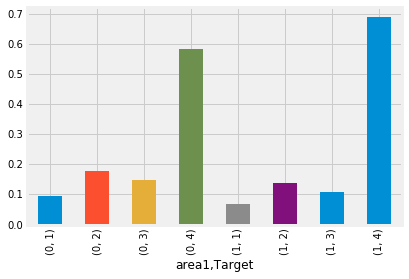

In [15]:
# The final redundant column is area2. 
# This means the house is in a rural zone, but it's redundant because 
# we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.
heads.drop(['area2'], axis=1, inplace=True)

# Observe how area affects the target variables
heads.groupby('area1')['Target'].value_counts(normalize=True).sort_index().plot(kind="bar")

Notes:
- It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

## Data Enginnering: Feature Creation

### Ordinal Variables

In [16]:
def get_similar_cols(data, groupby_format):
    """Returns columns that follow a similar groupby_format"""
    return data.filter(like=groupby_format, axis=1).columns.tolist()

In [17]:
# Wall Ordinal Variables

walls_columns = get_similar_cols(all_data, groupby_format='epared')
heads['walls'] = np.argmax(np.array(heads[walls_columns]), axis=1)
heads.drop(walls_columns, axis=1, inplace=True)

In [18]:
# Roof Ordinal Variables

roof_columns = get_similar_cols(all_data, groupby_format='etecho')
heads['roof'] = np.argmax(np.array(heads[roof_columns]), axis=1)
heads.drop(roof_columns, axis=1, inplace=True)

In [19]:
# Floor Ordinal Variables

floor_columns = get_similar_cols(all_data, groupby_format='eviv')
heads['floor'] = np.argmax(np.array(heads[floor_columns]), axis=1)
heads.drop(floor_columns, axis=1, inplace=True)

Notes:
- This new feature may be useful because it seems like a Target of 4 (the lowes poverty level) tends to have higher values of the 'house quality' variable. 

In [21]:
# Percentage of the each target for each ordinal wall+roof+floor value

counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(
    normalize=True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head(5)

,walls+roof+floor,Target,Normalized Count
0,0,4,0.376404
1,0,2,0.320225
2,0,1,0.162921
3,0,3,0.140449
4,1,4,0.323529


In [22]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) + 
                        heads['pisonotiene'] + heads['abastaguano'] + 
                        (heads['cielorazo'] == 0))

In [25]:
# Lastly, creating some percentage values
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Data Analysis

### Household Variables
There are a numerous method to measure to relationship btw two variables:
- The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables 
- The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables
- The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.


Pearson Correlation Guidelines:
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [26]:
# Only focusing on the training set
heads_train = heads.loc[heads['Target'].notnull(), :].copy()
heads_train['Target'] = heads_train['Target'].astype('int64')
pcorrs = pd.DataFrame(heads_train.corr()['Target'].sort_values(ascending=False)).rename(columns=
                                                                        {"Target": 'P_corr'}).reset_index()

# Top positive correlated Values
pcorrs = pcorrs.rename(columns={'index': 'feature'})
pcorrs.head(6)[1:]

,feature,P_corr
1,meaneduc,0.333652
2,walls+roof+floor,0.332446
3,floor,0.307605
4,phones-per-capita,0.299026
5,walls,0.298737


In [27]:
# Top negative correlated values
pcorrs.dropna().tail(5)

,feature,P_corr
87,r4m1,-0.209479
88,overcrowding,-0.234954
89,r4t1,-0.260917
90,hogar_nin,-0.266309
91,warning,-0.301791


Notes:
- Negative correlation: as we increase the value, poverty will increase. E.g. as our warning increases, the level of poverty will begin to decrease. 
- Overcrowing and hogar_nin (children under the age of 19) worsen poverty for households.
- For the positive values, walls, roof, and floor indicates that an improvement in those variables will eventually decrease poverty.


Spearman Correlation:

In [28]:
import warnings
from scipy.stats import spearmanr

warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(heads_train[c], heads_train['Target']).correlation)
        pvalues.append(spearmanr(heads_train[c], heads_train['Target']).pvalue)

# Top Positive correlated values
scorrs = pd.DataFrame({'feature': feats, 'S_corr': scorr, 'pvalue': pvalues}).sort_values('S_corr', ascending=False)
scorrs.head(5)

,feature,S_corr,pvalue
85,walls+roof+floor,0.338791,9.539346e-81
88,phones-per-capita,0.337377,4.760104e-80
84,floor,0.309638,4.466091e-67
22,cielorazo,0.300996,2.611808e-63
82,walls,0.298963,1.925370e-62


In [29]:
# Top negative correlated values
scorrs.dropna().tail(5)

,feature,S_corr,pvalue
7,pisocemento,-0.209387,8.270816e-31
69,r4t1,-0.219226,1.112230e-33
74,hogar_nin,-0.236225,5.567218e-39
57,dependency,-0.281516,2.792620e-55
86,warning,-0.307326,4.682829e-66


In [30]:
# Notice that both correlation matrix have identical values
# lets find their differences

corrs = pcorrs.merge(scorrs, on='feature')
corrs['diff'] = corrs['P_corr'] - corrs['S_corr']
corrs['abs_diff'] = np.abs(corrs['diff'])
corrs.sort_values(by='diff', ascending=False).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
77,dependency,-0.126465,-0.281516,2.792620e-55,0.155051,0.155051
31,edjefa,0.052310,0.005114,7.804715e-01,0.047197,0.047197
10,edjefe,0.235687,0.214736,2.367521e-32,0.020951,0.020951
46,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549,0.016549
39,techozinc,0.014357,0.003404,8.528369e-01,0.010954,0.010954


In [31]:
# Top difference variables for correlation
corrs.sort_values(by='diff', ascending=True).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
19,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119,0.071119
88,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691,0.041691
3,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351,0.038351
86,r4m1,-0.209479,-0.171953,3.649343e-21,-0.037526,0.037526
89,hogar_nin,-0.266309,-0.236225,5.567218e-39,-0.030084,0.030084


In [33]:
# Storing the household columns
household_feats = list(heads.columns)

### Individial Variables

In [34]:
ind = all_data[id_+ind_bool+ind_ordered]
ind.shape

(33413, 40)

In [35]:
corr_matrix, corrs_to_drop = get_corrs_matrix(ind)
corrs_to_drop

['female']

In [36]:
# We already have the male variable, lets keep the female variables
ind.drop(['male'], axis=1, inplace=True)

In [37]:
instl_vars = get_similar_cols(ind, 'instl')
ind[instl_vars].head(5)

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [40]:
ind.shape

(33413, 40)

## Data Engineering

In [41]:
# An important component woul dbe to find the ratio of specific metrics
# Normalizing the value to an apprioate metrics could be useful to find its improtance 

# The total number of schooling by age could reveal if their education has an important weight in their lvies
ind['escolari/age'] = ind['escolari']/ind['age']

# The level of education by their age
ind['instl_var/age'] = ind['instl_var']/ind['age']

# We can also calculate the years behind in school. Could they be old and still in school?
ind['rez_esc/age'] = ind['rez_esc']/ind['age']

In [42]:
# Other than ratio, we could find similar items
# e.g., we could at the tech gadgets in a household
ind['tech_gadgets'] = ind['mobilephone'] + ind['v18q']

### Feature Enginnering: Aggregations

In [43]:
# Creating the range functions
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'


# Group and aggregate
ind_agg = ind.drop(['Target'], axis=1).groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...   rez_esc/age  \
           min max sum count  std range_ min max sum count  ...           sum   
idhogar                                                     ...                 
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...           0.0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...           0.0   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...           0.0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...           0.0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...           0.0   

                            tech_gadgets                            
          count  std range_          min max sum count  std range_  
idhogar                                                             
000a08204     3  0.0    0.0            2   2   6     3  0.0      0  
000bce7c4     2  0.0    0.0            1   1   2     2  0.0      0  
001845fb0     3  0.0    0.0            1   1   4     4  0.0      0  
001ff74ca     1  NaN    0.0            2   2   4     2  0.0      0  
003123ec2     4  0.0    0.0            1   1   4     4  0.0      0  

[5 rows x 240 columns]

In [44]:
# Renaming the aggreagation columns
new_col = []
for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{col}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head(5)

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,rez_esc/age-sum,rez_esc/age-count,rez_esc/age-std,rez_esc/age-range_,tech_gadgets-min,tech_gadgets-max,tech_gadgets-sum,tech_gadgets-count,tech_gadgets-std,tech_gadgets-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.0,3,0.0,0.0,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.0,2,0.0,0.0,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.0,3,0.0,0.0,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.0,1,NaN,0.0,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.0,4,0.0,0.0,1,1,4,4,0.0,0


In [45]:
# Removing the variables that are redundant
corr_matrix, ind_agg_to_drop = get_corrs_matrix(ind_agg)
len(ind_agg_to_drop)

117

In [46]:
# Storing the individual variables
ind_agg = ind_agg.drop(ind_agg_to_drop, axis=1)
ind_feats = ind_agg.columns.tolist()

In [47]:
# Merging with household data
final_ = heads.merge(ind_agg, on='idhogar', how='left')

print("Shape of the final dataset is {}".format(final_.shape))

Shape of the final dataset is (10307, 218)


In [48]:
final_.head(5)

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-sum,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_
0,0,0,1,1,1,0,0,0,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,0,0,1,1,0,0,0,0,0,1,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,0,0,1,1,0,0,0,0,0,1,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,0,0,1,1,1,0,0,0,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


## Data Analysis
- Will continue to do further research

In [49]:
final_['Target'] = final_['Target'].dropna().astype('int64')
corrs = final_.corr()['Target']

# Most positives values related to target
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [50]:
# Most negative correlated values
corrs.sort_values().dropna().tail(6)[:5]

instlevel8-max      0.317815
walls+roof+floor    0.332446
meaneduc            0.333652
instl_var-max       0.368229
escolari-max        0.373091
Name: Target, dtype: float64

In [54]:
# Finding female head gender
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final_ = final_.merge(head_gender, on='idhogar', how='left').rename(columns={'female': 'female-head'})

In [55]:
# Understanding the
final_.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

In [58]:
final_.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


Notes:
- Despite females having higher levels of education, we can see that they will have higher less of poverty if they are the head of the household.

## Saving Datasets

In [60]:
final_.to_pickle('./pickles/final.pkl')

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [21]:
final = pd.read_pickle("./pickles/final.pkl")
test_set = pd.read_pickle("./pickles/test.pkl")

# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extracting the training/testing set
train_on = final[final['Target'].notnull()]
train_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

test_on = final[final['Target'].isnull()]
test_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

# Submission base which is used for making submissions to the competition
submission_base = test_set[['Id', 'idhogar']].copy()

test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

/Users/alexguanga/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds=5, return_preds=False, hyp=None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                  'min_child_samples': 10, 
                  'num_leaves': 36, 'reg_alpha': 0.76, 
                  'reg_lambda': 0.43, 
                  'subsample_for_bin': 40000, 
                  'subsample': 0.54, 
                  'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective='multiclass', n_jobs=-1, 
                               n_estimators=10000, #n_estimators is 10000: large enough to have no affect
                               random_state=10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits=nfolds, shuffle=True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds=100, 
                  eval_metric=macro_f1_score,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_names=['train', 'valid'],
                  verbose=200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

In [33]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [19]:
# Dataframe to hold results
model_results = pd.DataFrame(columns=['model', 'cv_mean', 'cv_std'])

In [17]:
optimize_file = pd.read_csv('./optimization.csv')
top_optimizations = optimize_file.sort_values(by='score', ascending=False).head(10)
top_optimizations.reset_index(inplace=True)

In [18]:
top_optimizations[['hyperparameters', 'score']]

,hyperparameters,score
61,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.452413
89,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.445465
31,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.444979
99,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.444469
65,"{'boosting_type': 'goss', 'colsample_bytree': ...",0.443707
63,"{'boosting_type': 'goss', 'colsample_bytree': ...",0.441446
90,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.441056
98,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.438574
80,"{'boosting_type': 'goss', 'colsample_bytree': ...",0.438480
35,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.438333


In [31]:
import ast 
best_hyp = ast.literal_eval(top_optimizations.loc[0, "hyperparameters"])
best_hyp 

{'boosting_type': 'dart',
 'colsample_bytree': 0.6656610653879056,
 'learning_rate': 0.15654386057087114,
 'limit_max_depth': False,
 'max_depth': -1,
 'min_child_samples': 25,
 'num_leaves': 28,
 'reg_alpha': 0.34028648714401466,
 'reg_lambda': 0.4969925318931504,
 'subsample_for_bin': 60000,
 'drop_rate': 0.39401307778070693,
 'subsample': 0.9522476606817002,
 'subsample_freq': 6,
 'n_estimators': 86}

In [34]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, 
                                             nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)


In [37]:
submission.to_csv('gbm_baseline_OPT_10fold.csv')